<a href="https://colab.research.google.com/github/kamilwyszynski/gnn_training_set_reduction_testing/blob/main/GNN_training_set_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

### Installations

In [2]:
!pip install --upgrade pip
!pip install torch-geometric
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch_sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html

     |████████████████████████████████| 1.5MB 8.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 186 kB 9.2 MB/s 
     |████████████████████████████████| 231 kB 15.7 MB/s 
     |████████████████████████████████| 2.2 MB 15.5 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-py3-none-any.whl size=322718 sha256=f505857ea1b2d102d49fed5a6e10073923ae1bd671f12d627f5228fcf06b6232
  Stored in directory: /root/.cache/pip/wheels/55/be/05/a068e58b901163f619e69824868d3ca17171b1482446f585d8
Successfully built torch-geometric
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 11.9 MB 166 kB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 24.3 MB 1.3 MB/s 
Looking in links: https://

### Modules

In [3]:
import torch_geometric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
%matplotlib inline
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 150})'''))

<IPython.core.display.Javascript object>

### Helper functions

* `print_dataset_details` - 
* `get_base_prediction_rate` - 
* `train` - One-pass train function
* `test` - Test function
* `train_epochs` - Train process function that displays loss and accuracy info
* `test_accuracy_distribution` - Function printing out the prediction accuracy accross different classes
* `get_reduced_train_dataset` - Get a dataset with reduced train mask
* `get_trained_gcn_model` - Create, train and return a model
* `visualize` - Graph visualisation
* `perform_test_series` - Perform an entire test set

In [4]:
def print_dataset_details(dataset):
    print()
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')

    data = dataset[0]  # Get the first graph object.

    print()
    print(data)
    print('===========================================================================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def get_base_prediction_rate(data):
    largest_class = max([np.sum(data.y.numpy() == i) for i in data.y.unique().numpy()])
    return round(largest_class / len(data.y), 3)

def train(model, data, optimizer, criterion):
  model.train()
  optimizer.zero_grad()  # Clear gradients.
  out = model(data.x, data.edge_index)  # Perform a single forward pass.
  loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
  loss.backward()  # Derive gradients.
  optimizer.step()  # Update parameters based on gradients.
  return loss

def test(model, data):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)  # Use the class with highest probability.
  test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

def train_epochs(model, data, optimizer, criterion, epochs=100, checkpoints=[]):
  for epoch in range(1, epochs+1):
    loss = train(model, data, optimizer, criterion)

    if epoch in checkpoints:
      acc = test(model, data)
      print(f'Epoch: {epoch:03d}\n\tLoss: {loss:.4f}\n\tAccuracy: {100*acc:.2f}\n')

def test_accuracy_distribution(model, data, print_details=False):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    correct_classes = data.y[data.test_mask]
    predicted_classes = pred[data.test_mask]

    test_correct = predicted_classes == correct_classes
    correctly_predicted_classes = correct_classes[test_correct] # Get only correctly predicted

    correctly_predicted = []
    accuracy = []

    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
    if print_details:
        print('Test classes:')
    for c in data.y.unique().numpy():
        num_of_correct_nodes = (correctly_predicted_classes==c).sum()
        num_of_test_nodes = (correct_classes==c).sum()
        num_of_nodes = (data.y==c).sum()
        if print:
            print(f'\nClass {c}: \
            \n\tCorrect nodes: {num_of_correct_nodes}\
            \n\tTest nodes: {num_of_test_nodes}\
            \n\tTest representation: {100*num_of_test_nodes/num_of_nodes:.2f}%\
            \n\tAccuracy: {100*num_of_correct_nodes/num_of_test_nodes:.2f}%')

        accuracy.append(float(100*num_of_correct_nodes/num_of_test_nodes))
        correctly_predicted.append(int(num_of_correct_nodes))

    return accuracy, correctly_predicted

def get_reduced_train_dataset(dataset, train_size):
    data = dataset[0]
    train_classes = data.y[data.train_mask].numpy()

    if (type(train_size) == float) & (train_size == 1):
        return data

    # Create a stratified sample of the default train set
    train_idx, _ = train_test_split(np.arange(len(train_classes)),
                                    train_size=train_size,
                                    stratify=train_classes)

    new_train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    new_train_mask[train_idx] = True
    data.train_mask = new_train_mask

    # print(f'Number of new train nodes: {int(new_train_mask.sum())}')

    return data

def get_trained_gcn_model(dataset, train_size=1.0, hidden_channels=16):
    # Get training data
    data = get_reduced_train_dataset(dataset, train_size)

    # Create model, opt and crit
    model = GCN(hidden_channels=16, dataset=dataset)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # train model
    train_epochs(model, data, optimizer, criterion, epochs=200)

    return model

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def perform_test_series(dataset, train_sizes):
    models = {}
    accuracies = {}
    class_accuracies = {}
    correct_predtions = {}
    number_of_training_nodes = {}

    # train and test models
    for i, train_size in enumerate(train_sizes, start=1):
        # Getting data here only to count the number of training nodes
        # There's probably a better way to do this
        data = get_reduced_train_dataset(dataset, train_size)

        model = get_trained_gcn_model(dataset, train_size)
        acc, corr = test_accuracy_distribution(model, dataset[0])

        models[f'Test {i}'] = model
        accuracies[f'Test {i}'] = test(model, dataset[0])
        class_accuracies[f'Test {i}'] = acc
        correct_predtions[f'Test {i}'] = corr
        number_of_training_nodes[f'Test {i}'] = int(data.train_mask.sum())

    # compose dataframes
    accuracy = pd.DataFrame({'Number of training nodes': number_of_training_nodes.values(),
                             'Accuracy (%)':accuracies.values()},
                            # columns=['Number of training nodes', 'Accuracy (%)'],
                            index=accuracies.keys())
    accuracy['Accuracy change (%)'] = accuracy['Accuracy (%)'].pct_change() * 100

    class_accuracy = pd.DataFrame(class_accuracies).T
    correct_predtion = pd.DataFrame(correct_predtions).T
    
    return {'accuracy': accuracy,
            'class_accuracy': class_accuracy, 
            'correct_predtion': correct_predtion,
            'models': models}

### GCN model

* Create a simple, reusable GCN model class

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, dataset):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Cora Dataset

### Dataset setup

* Get the Cora dataset
* Print out useful insights into the dataset

In [6]:
cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print_dataset_details(cora)

Processing...
Done!

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


### Train mask discovery

* Gather useful insights about the dafault training mask

In [7]:
data = cora[0]
default_training_mask = data.train_mask # Boolean Tensor
train_indices = default_training_mask.nonzero().flatten() # First 140 indices are train nodes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
train_classes = data.y[train_indices]

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
print('Training classes:')
for c in train_classes.unique():
    num_of_train_nodes = (train_classes==c).sum()
    num_of_nodes = (data.y==c).sum()
    print(f'\nClass {c}: \
    \n\tTrain nodes: {num_of_train_nodes}\
    \n\tOverall nodes: {num_of_nodes}\
    \n\tTraining representation: {100*num_of_train_nodes/num_of_nodes:.2f}%')

<IPython.core.display.Javascript object>

Training classes:

Class 0:     
	Train nodes: 20    
	Overall nodes: 351    
	Training representation: 5.70%

Class 1:     
	Train nodes: 20    
	Overall nodes: 217    
	Training representation: 9.22%

Class 2:     
	Train nodes: 20    
	Overall nodes: 418    
	Training representation: 4.78%

Class 3:     
	Train nodes: 20    
	Overall nodes: 818    
	Training representation: 2.44%

Class 4:     
	Train nodes: 20    
	Overall nodes: 426    
	Training representation: 4.69%

Class 5:     
	Train nodes: 20    
	Overall nodes: 298    
	Training representation: 6.71%

Class 6:     
	Train nodes: 20    
	Overall nodes: 180    
	Training representation: 11.11%


### Base prediction rate

This is an estimation of what is the lowest plausible accuracy for a specified datased 

In [9]:
get_base_prediction_rate(cora[0])

0.302

### Training set reduction

* Training the GCN model on the Cora dataset training masks with the following sizes:
    * __Test 1__: The default training mask
    * __Test 2__: 75% of the default training mask
    * __Test 3__: 50% of the default training mask
    * __Test 4__: 25% of the default training mask
    * __Test 5__: 28 nodes
    * __Test 6__: 21 nodes
    * __Test 7__: 14 nodes
    * __Test 8__: 7 nodes (Smallest mask possible)

In [10]:
# There is an error when going below 7 (which is the number of classes)
train_sizes = [1.0, 0.75, 0.5, 0.25] + [28, 21, 14, 7]
cora_outcome = perform_test_series(cora, train_sizes)

<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 100            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 76.92%

Class 1:             
	Correct nodes: 78            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 85.71%

Class 2:             
	Correct nodes: 128            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 88.89%

Class 3:             
	Correct nodes: 246            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 77.12%

Class 4:             
	Correct nodes: 131            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 87.92%

Class 5:             
	Correct nodes: 81            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 78.64%

Class 6:             
	Correct nodes: 50            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 78.12%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 104            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 80.00%

Class 1:             
	Correct nodes: 76            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 83.52%

Class 2:             
	Correct nodes: 123            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 85.42%

Class 3:             
	Correct nodes: 215            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 67.40%

Class 4:             
	Correct nodes: 129            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 86.58%

Class 5:             
	Correct nodes: 77            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 74.76%

Class 6:             
	Correct nodes: 42            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 65.62%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 115            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 88.46%

Class 1:             
	Correct nodes: 74            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 81.32%

Class 2:             
	Correct nodes: 131            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 90.97%

Class 3:             
	Correct nodes: 242            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 75.86%

Class 4:             
	Correct nodes: 108            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 72.48%

Class 5:             
	Correct nodes: 71            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 68.93%

Class 6:             
	Correct nodes: 31            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 48.44%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 69            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 53.08%

Class 1:             
	Correct nodes: 75            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 82.42%

Class 2:             
	Correct nodes: 123            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 85.42%

Class 3:             
	Correct nodes: 172            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 53.92%

Class 4:             
	Correct nodes: 101            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 67.79%

Class 5:             
	Correct nodes: 78            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 75.73%

Class 6:             
	Correct nodes: 51            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 79.69%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 105            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 80.77%

Class 1:             
	Correct nodes: 77            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 84.62%

Class 2:             
	Correct nodes: 124            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 86.11%

Class 3:             
	Correct nodes: 205            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 64.26%

Class 4:             
	Correct nodes: 87            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 58.39%

Class 5:             
	Correct nodes: 65            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 63.11%

Class 6:             
	Correct nodes: 38            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 59.38%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 38            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 29.23%

Class 1:             
	Correct nodes: 69            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 75.82%

Class 2:             
	Correct nodes: 128            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 88.89%

Class 3:             
	Correct nodes: 130            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 40.75%

Class 4:             
	Correct nodes: 97            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 65.10%

Class 5:             
	Correct nodes: 75            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 72.82%

Class 6:             
	Correct nodes: 37            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 57.81%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 12            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 9.23%

Class 1:             
	Correct nodes: 68            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 74.73%

Class 2:             
	Correct nodes: 83            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 57.64%

Class 3:             
	Correct nodes: 107            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 33.54%

Class 4:             
	Correct nodes: 89            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 59.73%

Class 5:             
	Correct nodes: 66            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 64.08%

Class 6:             
	Correct nodes: 22            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 34.38%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 9            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 6.92%

Class 1:             
	Correct nodes: 86            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 94.51%

Class 2:             
	Correct nodes: 6            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 4.17%

Class 3:             
	Correct nodes: 96            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 30.09%

Class 4:             
	Correct nodes: 65            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 43.62%

Class 5:             
	Correct nodes: 45            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 43.69%

Class 6:             
	Correct nodes: 9            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 14.06%


##### Test outcome analysis

**Accuray over different tests**

Visiblyon the two graphs below, the default training set can be reduced to 50% and even 25% of its original size (Test 1 size: 140, Test 3 size: 70, Test 4 size: 35) while still performing with a near intact accuracy (Test 1: 81.4%, Test 3: 77.5%, Test 4: 75.6%). 
<br>
<br>
<br>


..._That's only about 5% decrease in accuracy!_

In [12]:
cora_outcome['accuracy']['Accuracy change (%)'] = cora_outcome['accuracy']['Accuracy (%)'].pct_change() * 100

In [13]:
cora_outcome['accuracy']

,Number of training nodes,Accuracy (%),Accuracy change (%)
Test 1,140,0.814,NaN
Test 2,105,0.766,-5.896806
Test 3,70,0.772,0.783290
Test 4,35,0.669,-13.341969
Test 5,28,0.701,4.783259
Test 6,21,0.574,-18.116976
Test 7,14,0.447,-22.125436
Test 8,7,0.316,-29.306488


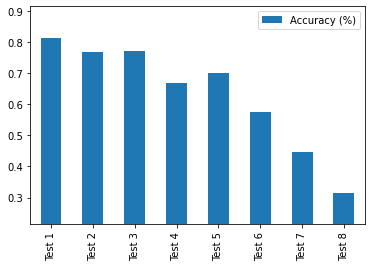

In [14]:
ymax = cora_outcome['accuracy']['Accuracy (%)'].max()+0.1
ymin = cora_outcome['accuracy']['Accuracy (%)'].min()-0.1
cora_outcome['accuracy'].plot(y='Accuracy (%)',kind='bar',ylim=(ymin, ymax))

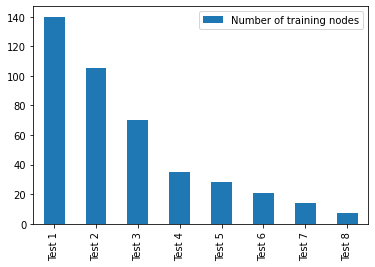

In [15]:
cora_outcome['accuracy'].plot(y='Number of training nodes',kind='bar')

In [16]:
cora_outcome

{'accuracy':         Number of training nodes  Accuracy (%)  Accuracy change (%)
 Test 1                       140         0.814                  NaN
 Test 2                       105         0.766            -5.896806
 Test 3                        70         0.772             0.783290
 Test 4                        35         0.669           -13.341969
 Test 5                        28         0.701             4.783259
 Test 6                        21         0.574           -18.116976
 Test 7                        14         0.447           -22.125436
 Test 8                         7         0.316           -29.306488,
 'class_accuracy':                 0          1          2  ...          4          5        6
 Test 1  76.923080  85.714287  88.888885  ...  87.919464  78.640778  78.1250
 Test 2  80.000000  83.516487  85.416664  ...  86.577179  74.757278  65.6250
 Test 3  88.461540  81.318680  90.972221  ...  72.483223  68.932037  48.4375
 Test 4  53.076923  82.417580  85.416664

### Attempt to better sample a default train set

* Creating a custom training mask (using stratified sampling) containing 100% nodes of the default training mask

##### Prepare dataset

In [17]:
data_test_5 = cora[0]

all_classes = data_test_5.y.numpy()
new_train_indices, _ = train_test_split(np.arange(len(all_classes)),
                                        train_size=140,
                                        stratify=all_classes)

new_train_mask = torch.zeros(data_test_5.num_nodes, dtype=torch.bool)
new_train_mask[new_train_indices] = True
data_test_5.train_mask = new_train_mask

print(f'Number of new train nodes: {int(new_train_mask.sum())}')

Number of new train nodes: 140


##### Create and train the model

In [18]:
model_test_5 = GCN(hidden_channels=16, dataset=cora)
optimizer_test_5 = torch.optim.Adam(model_test_5.parameters(), lr=0.01, weight_decay=5e-4)
criterion_test_5 = torch.nn.CrossEntropyLoss()

train_epochs(model_test_5, data_test_5, optimizer_test_5, criterion_test_5, 200, [50, 100, 150, 200])

Epoch: 050
	Loss: 1.2791
	Accuracy: 54.90

Epoch: 100
	Loss: 0.7370
	Accuracy: 69.20

Epoch: 150
	Loss: 0.5767
	Accuracy: 76.50

Epoch: 200
	Loss: 0.4091
	Accuracy: 78.30



##### Conclusion

* The accuracy of a model trained on this training dataset is actually lower than the default training dataset, therefore I'm assuming it's not worth exploring

In [19]:
test_5_accuracy, test_5_correctly_predicted = test_accuracy_distribution(model_test_5, data_test_5)

<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 101            
	Test nodes: 130            
	Test representation: 37.04%            
	Accuracy: 77.69%

Class 1:             
	Correct nodes: 63            
	Test nodes: 91            
	Test representation: 41.94%            
	Accuracy: 69.23%

Class 2:             
	Correct nodes: 131            
	Test nodes: 144            
	Test representation: 34.45%            
	Accuracy: 90.97%

Class 3:             
	Correct nodes: 264            
	Test nodes: 319            
	Test representation: 39.00%            
	Accuracy: 82.76%

Class 4:             
	Correct nodes: 126            
	Test nodes: 149            
	Test representation: 34.98%            
	Accuracy: 84.56%

Class 5:             
	Correct nodes: 78            
	Test nodes: 103            
	Test representation: 34.56%            
	Accuracy: 75.73%

Class 6:             
	Correct nodes: 20            
	Test nodes: 64            
	Test representation: 35.56%            
	Accuracy: 31.25%


# Pubmed Dataset

PubMed dataset, while similar to the Cora dataset used before is quite larger.
The dataset contains more than 19 000 node in it's graph (Comparing with about 2500 in Cora). Another difference betwwen the dataset is the amount of node classes; PubMed has 3 while Cora has 7.


<br>


It's similarities and differences with Cora makes the PubMed dataset a good candidate to perform further analysis on.

### Dataset setup

* Get thedataset
* Print out useful insights into the dataset

In [20]:
pubmed = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())
print_dataset_details(pubmed)

Processing...
Done!

Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


### Base prediction rate

This is an estimation of what is the lowest plausible accuracy for a specified datased 

In [21]:
get_base_prediction_rate(pubmed[0])

0.399

### Training set reduction

* Training the GCN model on the Cora dataset training masks with the following sizes:
    * __Test 1__: The default training mask
    * __Test 2__: 75% of the default training mask
    * __Test 3__: 50% of the default training mask
    * __Test 4__: 25% of the default training mask
    * __Test 5__: 9 nodes
    * __Test 6__: 6 nodes
    * __Test 7__: 3 nodes (Smallest mask possible)

In [ ]:
train_sizes = [1.0, 0.75, 0.5, 0.25] + [9, 6, 3]
pubmed_outcome = perform_test_series(pubmed, train_sizes)

<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 141            
	Test nodes: 180            
	Test representation: 4.39%            
	Accuracy: 78.33%

Class 1:             
	Correct nodes: 340            
	Test nodes: 413            
	Test representation: 5.34%            
	Accuracy: 82.32%

Class 2:             
	Correct nodes: 305            
	Test nodes: 407            
	Test representation: 5.17%            
	Accuracy: 74.94%


<IPython.core.display.Javascript object>


Class 0:             
	Correct nodes: 139            
	Test nodes: 180            
	Test representation: 4.39%            
	Accuracy: 77.22%

Class 1:             
	Correct nodes: 324            
	Test nodes: 413            
	Test representation: 5.34%            
	Accuracy: 78.45%

Class 2:             
	Correct nodes: 307            
	Test nodes: 407            
	Test representation: 5.17%            
	Accuracy: 75.43%


In [ ]:
ymax = pubmed_outcome['accuracy']['Accuracy (%)'].max()+0.1
ymin = pubmed_outcome['accuracy']['Accuracy (%)'].min()-0.1
pubmed_outcome['accuracy'].plot(y='Accuracy (%)',kind='bar',ylim=(ymin, ymax))

In [ ]:
pubmed_outcome['accuracy'].plot(y='Number of training nodes',kind='bar')

In [ ]:
pubmed_outcome

# CiteSeer Dataset

### Dataset setup

* Get the dataset
* Print out useful insights into the dataset

In [ ]:
citeseer = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
print_dataset_details(citeseer)

### Base prediction rate

This is an estimation of what is the lowest plausible accuracy for a specified datased 

In [ ]:
citeseer_base = get_base_prediction_rate(citeseer[0])
citeseer_base

### Training set reduction

* Training the GCN model on the Cora dataset training masks with the following sizes:
    * __Test 1__: The default training mask
    * __Test 2__: 75% of the default training mask
    * __Test 3__: 50% of the default training mask
    * __Test 4__: 25% of the default training mask
    * __Test 5__: 24 nodes
    * __Test 6__: 18 nodes
    * __Test 6__: 12 nodes
    * __Test 7__: 6 nodes (Smallest mask possible)

In [ ]:
train_sizes = [1.0, 0.75, 0.5, 0.25] + [24, 18, 12, 6]
citeseer_outcome = perform_test_series(citeseer, train_sizes)

In [ ]:
ymax = citeseer_outcome['accuracy']['Accuracy (%)'].max()+0.1
ymin = citeseer_outcome['accuracy']['Accuracy (%)'].min()-0.1
citeseer_outcome['accuracy'].plot(y='Accuracy (%)',kind='bar',ylim=(ymin, ymax))

In [ ]:
citeseer_outcome['accuracy'].plot(y='Number of training nodes',kind='bar')

In [ ]:
citeseer_outcome

# Tables and Graphs

In [ ]:
cora_outcome['accuracy']

In [ ]:
pubmed_outcome['accuracy']

In [ ]:
citeseer_outcome['accuracy']['Accuracy (%)']

In [ ]:
overall_accuracy = pd.DataFrame()

In [ ]:
overall_accuracy['Cora'] = cora_outcome['accuracy']['Accuracy (%)']
overall_accuracy['PubMed'] = pubmed_outcome['accuracy']['Accuracy (%)']
overall_accuracy['CiteSeer'] = citeseer_outcome['accuracy']['Accuracy (%)']

In [ ]:
overall_accuracy.plot(kind='bar', ylabel='Accuracy (%)')

In [ ]:
overall_accuracy